In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.preprocessing.image.load_img("./Pictures/anime/IMG_20210603_090034_347.jpg")
result_prefix = "anime"

2022-09-04 20:57:22.328267: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-04 20:57:22.336286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-04 20:57:22.336319: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


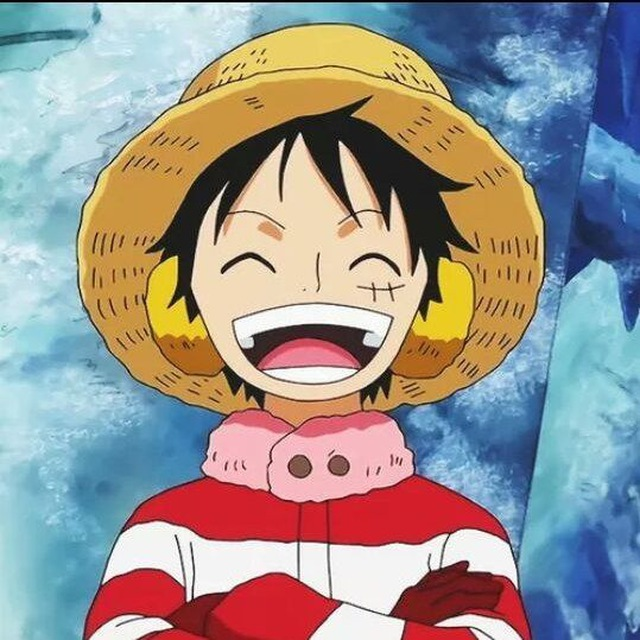

In [2]:
base_image_path

In [3]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

In [4]:
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 10  # Number of ascent steps per scale
max_loss = 10.0

In [5]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

In [6]:
def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    print(x.shape)
    x = x.reshape((x.shape[1], x.shape[2], 3))
    print("After reshape",x.shape)
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    print("After undo",x.shape)
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    print("After clip")
    return x

In [8]:
# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
output_dict = dict(
    [
        (layer.name,layer.output)
        for layer in model.layers if layer.name in layer_settings
    ]
)
# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=output_dict)

In [9]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

In [10]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

In [11]:
original_img = preprocess_image("./Pictures/20545155.jpg")

original_shape = original_img.shape[1:3]

In [12]:
y = original_img-0.2

In [13]:
z = original_img+1.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 864x864 with 0 Axes>

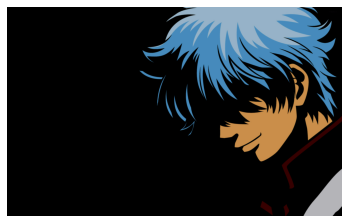

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
fig , ax = plt.subplots(1,1)

ax.axis("off")
ax.imshow(y[0])
fig.savefig("sd.png")

In [15]:
original_img.shape

(1, 1600, 2560, 3)

In [16]:
successive_shapes = [original_shape]

In [17]:
successive_shapes

[(1600, 2560)]

In [18]:
for i in range(1,num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

In [19]:
successive_shapes

[(1600, 2560), (1142, 1828), (816, 1306)]

In [20]:
successive_shapes = successive_shapes[::-1]

In [21]:
successive_shapes

[(816, 1306), (1142, 1828), (1600, 2560)]

In [22]:
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

In [27]:
original_img.shape

(1, 1600, 2560, 3)

In [24]:
shrunk_original_img.shape

TensorShape([1, 816, 1306, 3])

In [25]:
img = tf.identity(original_img)

In [28]:
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

Processing octave 0 with shape (816, 1306)
Shape: (816, 1306)
(1, 816, 1306, 3)
... Loss value at step 0: 0.60
... Loss value at step 1: 0.67
... Loss value at step 2: 0.84
... Loss value at step 3: 1.05
... Loss value at step 4: 1.26
... Loss value at step 5: 1.45
... Loss value at step 6: 1.66
... Loss value at step 7: 1.86
... Loss value at step 8: 2.06
... Loss value at step 9: 2.26
(1, 816, 1306, 3)
Same Size Original (1, 816, 1306, 3)
Processing octave 1 with shape (1142, 1828)
Shape: (1142, 1828)
(1, 1142, 1828, 3)
... Loss value at step 0: 1.03
... Loss value at step 1: 1.41
... Loss value at step 2: 1.70
... Loss value at step 3: 1.94
... Loss value at step 4: 2.20
... Loss value at step 5: 2.45
... Loss value at step 6: 2.68
... Loss value at step 7: 2.93
... Loss value at step 8: 3.17
... Loss value at step 9: 3.41
(1, 1142, 1828, 3)
Same Size Original (1, 1142, 1828, 3)
Processing octave 2 with shape (1600, 2560)
Shape: (1600, 2560)
(1, 1600, 2560, 3)
... Loss value at step

In [29]:
keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

(1, 1600, 2560, 3)
After reshape (1600, 2560, 3)
After undo (1600, 2560, 3)
After clip
